# NST modificando DETALLES

In [1]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

import tensorflow as tf

In [2]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)


In [3]:
# install tensorflow_hub
content_image = PIL.Image.open('valencia.png')
style_image = PIL.Image.open('oxford.png')

Imsize = 200

In [4]:
content_image = np.asarray(content_image.resize((Imsize,Imsize)))
style_image = np.asarray(style_image.resize((Imsize,Imsize)))

In [5]:
content_image = content_image[:,:,0:3].astype(np.float32)/255
style_image = style_image[:,:,0:3].astype(np.float32)/255

style_image.shape

(200, 200, 3)

In [6]:
content_image = np.expand_dims(content_image,0)
style_image = np.expand_dims(style_image,0)
content_image.shape

(1, 200, 200, 3)

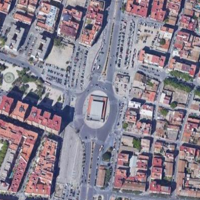

In [7]:
tensor_to_image(content_image[0,:,:,:])

## Construir modelo

In [14]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)


### Construye el modelo

In [15]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [16]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()


block1_conv1
  shape:  (1, 200, 200, 64)
  min:  0.0
  max:  728.4817
  mean:  27.123232

block2_conv1
  shape:  (1, 100, 100, 128)
  min:  0.0
  max:  2988.788
  mean:  180.43889

block3_conv1
  shape:  (1, 50, 50, 256)
  min:  0.0
  max:  6730.1504
  mean:  169.59895

block4_conv1
  shape:  (1, 25, 25, 512)
  min:  0.0
  max:  16111.311
  mean:  592.8773

block5_conv1
  shape:  (1, 12, 12, 512)
  min:  0.0
  max:  1948.7217
  mean:  42.644035



### Calcular estilo

In [17]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)


### Extraer estilo y contenido

In [18]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}


In [19]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.009272274
    max:  15027.632
    mean:  779.51807

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  276102.94
    mean:  29934.062

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  927739.7
    mean:  29365.727

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  10294751.0
    mean:  335908.38

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  239529.19
    mean:  1964.2351

Contents:
   block5_conv2
    shape:  (1, 12, 12, 512)
    min:  0.0
    max:  710.59656
    mean:  17.308924


### Ejecutar descenso de gradiente

In [20]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [23]:
def clip_0_1(image):
      return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [41]:
opt = tf.optimizers.Adam(learning_rate=0.1, beta_1=0.99, epsilon=1e-1)

In [42]:
# WEIGHTS
# style_weight=1e-10 # ERROR de 3
# content_weight=1e-3  # ERROR de 3

style_weight=1e-8
content_weight=1e-4

# Empezar con la del contenido
image = tf.Variable(content_image)
# Empezar con ruido
image = tf.Variable(np.random.rand(content_image.shape[0],content_image.shape[1],content_image.shape[2],content_image.shape[3]))

In [43]:
 def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss

    return loss, style_loss, content_loss


In [44]:
loss, style_loss, content_loss = style_content_loss(extractor(content_image))
print(np.array(loss), np.array(style_loss), np.array(content_loss))

loss, style_loss, content_loss = style_content_loss(extractor(style_image))
print(np.array(loss), np.array(style_loss), np.array(content_loss))

242.3397 242.3397 0.0
0.28684404 0.0 0.28684404


In [45]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))


In [46]:
# train_step(image)
# train_step(image)


L_cont = np.array([])
L_style = np.array([])

for n in range(0,2000):
    train_step(image)

    outputs = extractor(image)
    loss, style_loss, content_loss = style_content_loss(outputs)
    print(np.array(loss), np.array(style_loss), np.array(content_loss))
    L_cont = np.append(L_cont,np.array(content_loss))
    L_style = np.append(L_style,np.array(style_loss))
    print(n)
# tensor_to_image(image[0,:,:,:])

605.9498 605.71155 0.2382894
0
432.51773 432.28253 0.23519777
1
332.92624 332.69025 0.23599912
2
273.15256 272.91385 0.2386976
3
240.43204 240.19077 0.24127604
4
225.06166 224.8181 0.2435539
5
219.24173 218.99547 0.24625802
6
214.98082 214.73135 0.24947026
7
207.68896 207.43652 0.25244805
8
196.95819 196.70316 0.25503668
9
185.432 185.17505 0.25696507
10
176.15201 175.8936 0.25840816
11
169.33095 169.07123 0.2597131
12
164.62741 164.36676 0.26065004
13
161.16739 160.90572 0.26167327
14
158.19162 157.92885 0.26277274
15
154.94823 154.68471 0.2635208
16
151.2733 151.00943 0.26387653
17
146.96613 146.70207 0.26405093
18
142.23227 141.96812 0.26414493
19
137.39839 137.13396 0.26444066
20
132.5028 132.23782 0.26498365
21
127.80852 127.54305 0.26546833
22
123.36359 123.09775 0.2658419
23
119.23265 118.96653 0.26611918
24
115.17642 114.90987 0.26655748
25
111.17784 110.91083 0.26701224
26
107.12906 106.86167 0.26739058
27
103.09697 102.82919 0.2677796
28
98.98141 98.71324 0.26816663
29
94.933

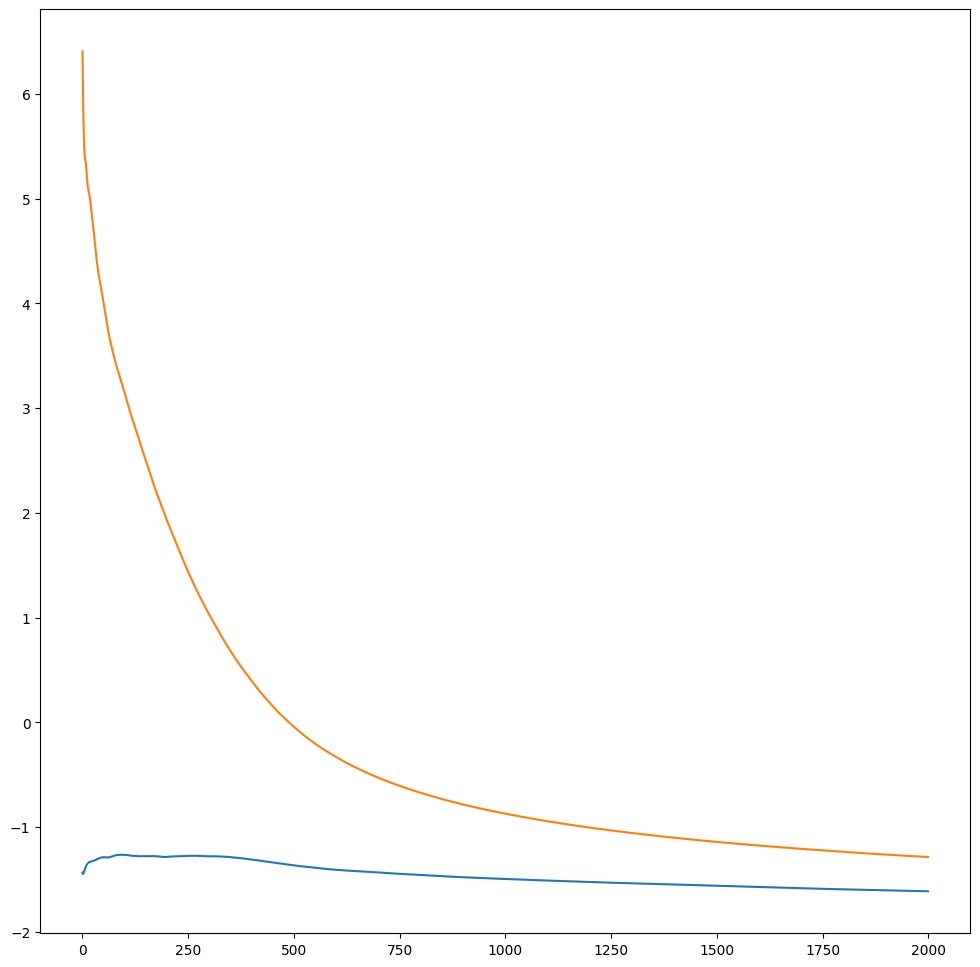

In [47]:
plt.plot(np.log(L_cont))
plt.plot(np.log(L_style))

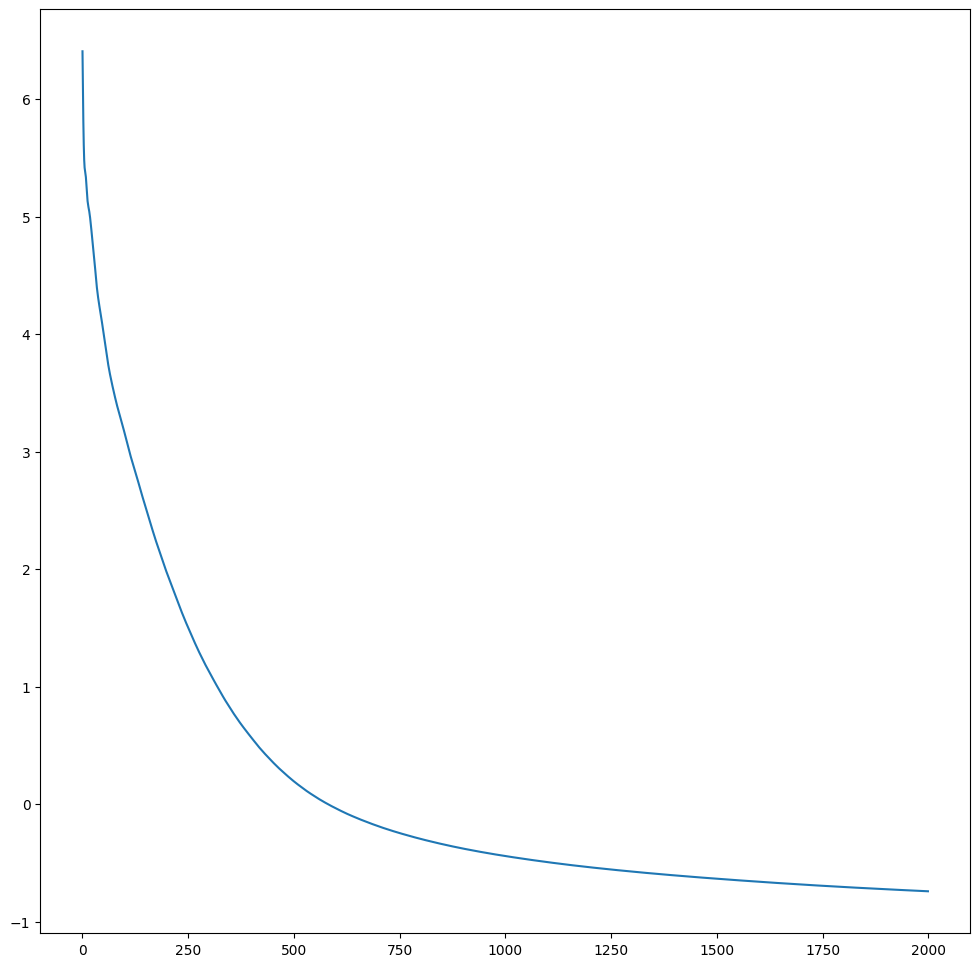

In [48]:

plt.plot(np.log(L_cont+L_style))

In [49]:
def plot_images(content_image, style_image, image):
    plt.subplot(1,3,1)
    plt.title("Content image")
    plt.imshow(content_image[0, :,:,:],vmin=0,vmax=1)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.title("Style image")
    plt.imshow(style_image[0, :,:,:],vmin=0,vmax=1)
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.title("Style-transfer image")
    plt.imshow(image[0, :,:,:],vmin=0,vmax=1)
    plt.axis('off')

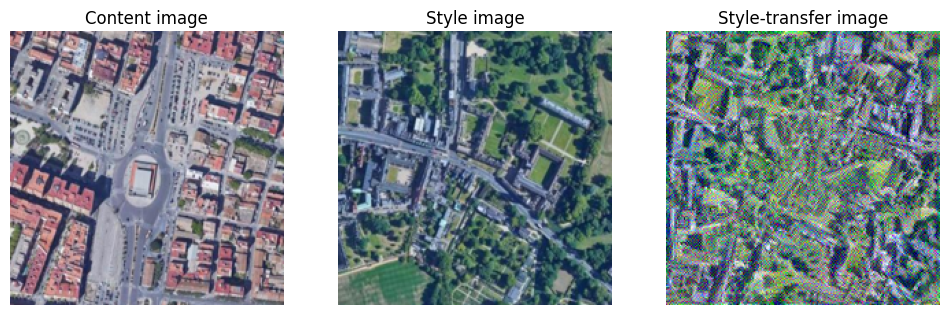

In [50]:

plot_images(content_image, style_image, image)